In [1]:
import formulaic
import pymc as pm
import pandas as pd

data = pd.read_csv("../../single_parameter/combined_data/statistics.csv")


# Dummy variables for Module and Parameters
model_formula = 'Coverage ~ 0 + C(TargetModule) + C(TuningParameters, contr.treatment("NONE"))'
design_matrix = formulaic.model_matrix(model_formula, data=data)

module_matrix = design_matrix.rhs.iloc[:, :24]
parameter_matrix = design_matrix.rhs.iloc[:, 24:]

# Dummy variables for interaction terms
model_formula = 'Coverage ~ 0 + C(TargetModule) : C(TuningParameters)'
design_matrix = formulaic.model_matrix(model_formula, data=data)

# Filter out columns that contain 'T.NONE' in their name
columns_to_drop = [col for col in design_matrix.rhs.columns if 'T.NONE' in col]

# Drop the identified columns
design_matrix.rhs.drop(columns=columns_to_drop, axis=1, inplace=True)
interaction_matrix = design_matrix.rhs.iloc[:,:]


In [2]:
with pm.Model() as model:
    # Global Intercept and standard deviation for Modules
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.5)
    
    # Standard Deviations for Modules, Parameters and Interactions
    sigma_a = pm.Exponential('sigma_a', 2.0)
    sigma_b = pm.Exponential('sigma_b', 5.0)
    sigma_g = pm.Exponential('sigma_g', 5.0)
    
    # Non-centered parameterizations
    a_offset = pm.Normal('a_offset', mu=0, sigma=1, shape=24)
    a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

    b_offset = pm.Normal('b_offset', mu=0, sigma=1, shape=12)
    b_p = pm.Deterministic('b_p', sigma_b * b_offset)

    g_offset = pm.Normal('g_offset', mu=0, sigma=1, shape=288)
    g_mp = pm.Deterministic('g_mp', sigma_g * g_offset)

    
    # Activate the correct dummy variables
    logit_a = pm.math.dot(module_matrix, a_m)
    logit_b = pm.math.dot(parameter_matrix, b_p)
    logit_g = pm.math.dot(interaction_matrix, g_mp)

    # Link function (logit), unbounded to (0,1) probability
    p = pm.Deterministic('p', pm.math.sigmoid(logit_a + logit_b + logit_g))
    
    # Beta distribution likelihood 
    theta = pm.Uniform('theta', 20, 200) # Disperion parameter
    Y_obs = pm.Beta('Y_obs', alpha=p*theta, beta=(1-p)*theta, observed=design_matrix.lhs['Coverage'])
    
    # Sample from the model
    trace = pm.sample(1000, chains=4,return_inferencedata=True, progressbar=True, target_accept=0.95)
    log_lik = pm.compute_log_likelihood(trace)
    
print("Model building complete.")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_bar, sigma_a, sigma_b, sigma_g, a_offset, b_offset, g_offset, theta]


Output()

In [ ]:
import arviz as az
import numpy as np

def logit_to_probability(logit_vals):
    """Apply logistic transformation to logit values."""
    return 1 / (1 + np.exp(-logit_vals))


def log_odds_to_or(log_odds):
    return np.exp(log_odds)

# Create a dictionary for the posterior
posterior_dict = {
    'a_m': trace.posterior['a_m'].values,
    'a_bar': trace.posterior['a_bar'].values,
    'sigma_a': trace.posterior['sigma_a'].values
    
}

for key, value in posterior_dict.items():
    posterior_dict[key] = logit_to_probability(value)


posterior_dict['theta'] = trace.posterior['theta'].values
posterior_dict['sigma_b'] = trace.posterior['sigma_b'].values 
posterior_dict['b_p'] = trace.posterior['b_p'].values 
posterior_dict['sigma_g'] = trace.posterior['sigma_g'].values 
posterior_dict['g_mp'] = trace.posterior['g_mp'].values

# Create an InferenceData object
infdata = az.from_dict(posterior=posterior_dict)

# Generate a summary table with the mean and 89% HDI for all variables
summary = az.summary(infdata, hdi_prob=0.89)
summary.to_csv('my_data.csv')

array([[<Axes: title={'center': 'sigma_a'}>,
        <Axes: title={'center': 'sigma_a'}>],
       [<Axes: title={'center': 'a_m'}>, <Axes: title={'center': 'a_m'}>],
       [<Axes: title={'center': 'sigma_b'}>,
        <Axes: title={'center': 'sigma_b'}>],
       [<Axes: title={'center': 'b_p'}>, <Axes: title={'center': 'b_p'}>],
       [<Axes: title={'center': 'sigma_g'}>,
        <Axes: title={'center': 'sigma_g'}>],
       [<Axes: title={'center': 'g_mp'}>,
        <Axes: title={'center': 'g_mp'}>]], dtype=object)

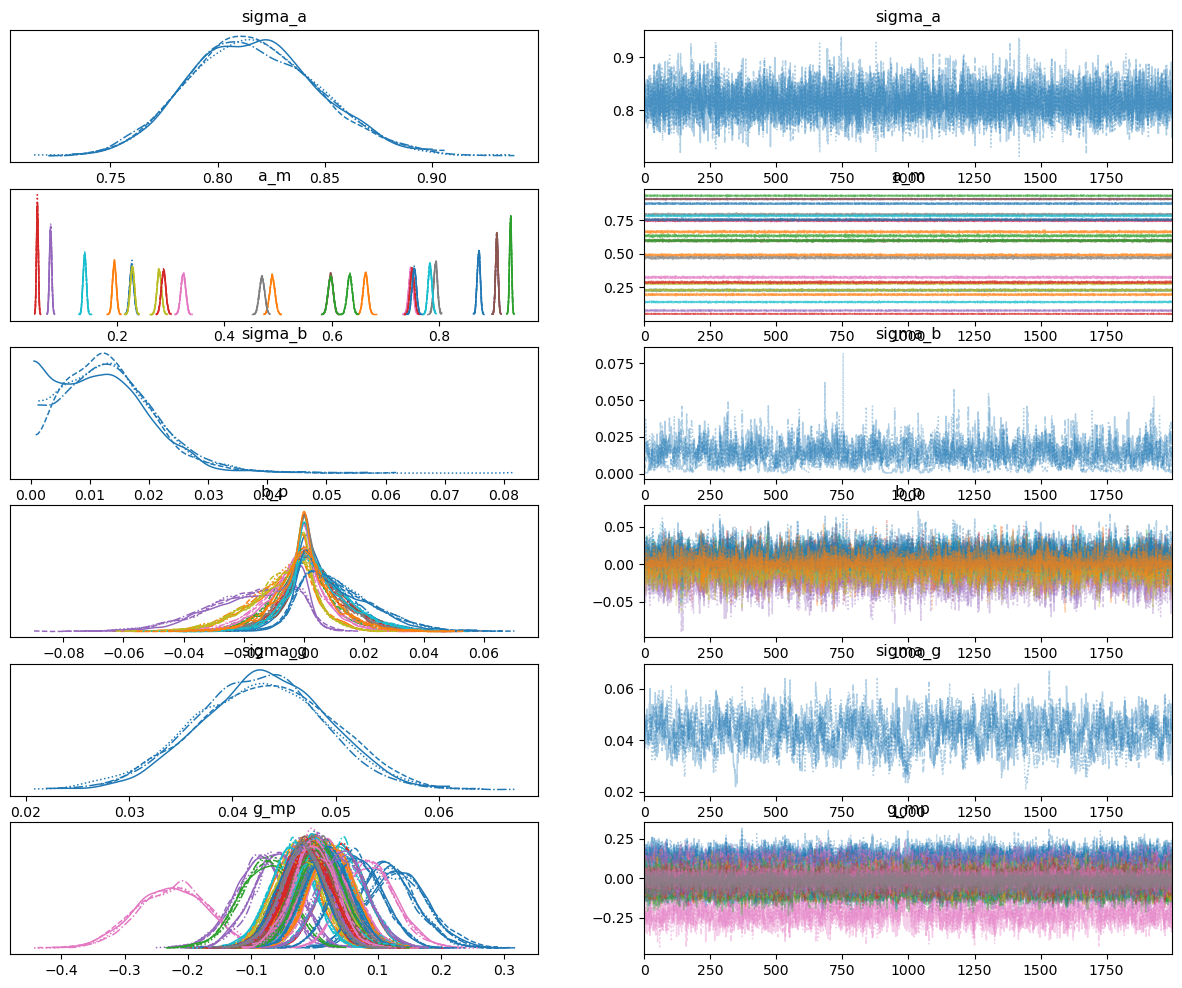

In [ ]:
az.plot_trace(posterior_dict, var_names=['sigma_a', 'a_m', 'sigma_b', 'b_p', 'sigma_g', 'g_mp', ], figsize=(15, 12))

In [ ]:
import arviz as az

az.to_netcdf(trace, "model_3_trace.nc")

'model_3_trace.nc'

In [ ]:
az.loo(az.from_netcdf("model_3_trace.nc"))

Computed from 8000 posterior samples and 9360 observations log-likelihood matrix.

         Estimate       SE
elpd_loo 13388.69   235.44
p_loo      129.44        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     9360  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [3]:
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import interact

def calc_prior_dist(a,b,g):


    with pm.Model() as model:
        # Global Intercept and standard deviation for Modules
        a_bar = pm.Normal('a_bar', mu=0, sigma=1.5)
        
        # Standard Deviations for Modules, Parameters and Interactions
        sigma_a = pm.Exponential('sigma_a', a)
        sigma_b = pm.Exponential('sigma_b', b)
        sigma_g = pm.Exponential('sigma_g', g)
        
        # Module-specific intercepts
        a_m = pm.Normal('a_m', mu=a_bar, sigma=sigma_a )

        # Parameter effects
        b_p = pm.Normal('b_p', mu=0, sigma = sigma_b)

        # Interaction effects
        g_mp = pm.Normal('g_mp', mu=0, sigma = sigma_g)
        
        p_before = pm.Deterministic('p_before', (a_m + b_p + g_mp))

        # Link function (logit), unbounded to (0,1) probability
        p = pm.Deterministic('p', pm.math.sigmoid(a_m + b_p + g_mp))
        
        # Beta distribution likelihood 
        theta = pm.Uniform('theta', 20, 200) # Disperion parameter
    
        # Sample Priors
        idata = pm.sample_prior_predictive(samples=10000)

    # Fetch and flatten priors
    prior_a_bar = idata.prior['a_bar'].values.flatten()
    prior_sigma_a = idata.prior['sigma_a'].values.flatten()
    prior_a_m = idata.prior['a_m'].values.flatten()
    prior_sigma_b = idata.prior['sigma_b'].values.flatten()
    prior_b_p = idata.prior['b_p'].values.flatten()
    prior_sigma_g = idata.prior['sigma_g'].values.flatten()
    prior_g_mp = idata.prior['g_mp'].values.flatten()
    prior_p_before = idata.prior['p_before'].values.flatten()
    prior_p = idata.prior['p'].values.flatten()
    prior_theta = idata.prior['theta'].values.flatten()

    print(prior_p_before[0:10])

    # Sample one data point from each combinatio0.00001
    simulated_observations = np.random.beta(a=prior_p * prior_theta, b=(1 - prior_p) * prior_theta)


    plt.figure(figsize=(20, 15))

    # a_bar
    plt.subplot(5, 2, 1)
    sns.histplot(prior_a_bar, color='blue')
    plt.title('Prior Distribution of a_bar - Normal(0, 1.5)')
    plt.xlabel('a_bar')
    plt.ylabel('Density')

    # sigma
    plt.subplot(5, 2, 2)
    sns.histplot(prior_sigma_a, color='red')
    plt.title('Prior Distribution of sigma - Exponential(1.5)')
    plt.xlabel('sigma')
    plt.ylabel('Density')

    # a_m
    plt.subplot(5, 2, 3)
    sns.histplot(prior_a_m, color='green')
    plt.title('Prior Distribution of a_m - Normal(a_bar, sigma)')
    plt.xlabel('a_m')
    plt.ylabel('Density')

    # sigma
    plt.subplot(5, 2, 4)
    sns.histplot(prior_sigma_b, color='salmon')
    plt.title('Prior Distribution of sigma - Exponential(1.5)')
    plt.xlabel('sigma')
    plt.ylabel('Density')

    # b_p
    plt.subplot(5, 2, 5)
    sns.histplot(prior_b_p, color='pink')
    plt.title('Prior Distribution of b_p - Normal(a_bar, sigma)')
    plt.xlabel('b_p')
    plt.ylabel('Density')

    # sigma
    plt.subplot(5, 2, 6)
    sns.histplot(prior_sigma_b, color='brown')
    plt.title('Prior Distribution of sigma - Exponential(1.5)')
    plt.xlabel('sigma')
    plt.ylabel('Density')

    # g_mp
    plt.subplot(5, 2, 7)
    sns.histplot(prior_g_mp, color='yellow')
    plt.title('Prior Distribution of b_p - Normal(a_bar, sigma)')
    plt.xlabel('g_mp')
    plt.ylabel('Density')

    # p
    plt.subplot(5, 2, 8)
    sns.histplot(prior_p, bins=np.arange(0, 1.05, 0.05), color='purple')
    plt.title('Prior Distribution of p - Logistic / Inverse Logit')
    plt.xlabel('p')
    plt.ylabel('Density')

    # theta
    plt.subplot(5, 2, 9)
    sns.histplot(prior_theta, color='orange')
    plt.title('Prior Distribution of theta - Unifrom(10,200)')
    plt.xlabel('p_before')
    plt.ylabel('Density')

    plt.tight_layout()
    plt.show()

    # Predicated observations
    plt.figure(figsize=(8, 6))
    sns.histplot(simulated_observations, bins=np.arange(0, 1.05, 0.05), color='darkcyan')
    plt.title('Simulated Observations of Coverage using priors ')
    plt.xlabel('Values')
    plt.ylabel('Density')
    plt.show()


# Interactive sliders
interact(calc_prior_dist, a=(0.01, 5.0, 0.01), b=(0.01, 5.0, 0.01), g=(0.01, 5.0, 0.01))

interactive(children=(FloatSlider(value=2.5, description='a', max=5.0, min=0.01, step=0.01), FloatSlider(value…

<function __main__.calc_prior_dist(a, b, g)>

In [8]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact

def plot_p_distribution(a, b, c):
    with pm.Model() as bruh:
        a_bar = pm.Normal('a_bar', mu=0, sigma=1.5)
        #a_bar = 0
        print(a)
        sigma_a = pm.Exponential('sigma_a', a)
        #print(b)
        sigma_b = pm.Exponential('sigma_b', b)
        #print(g)
        sigma_g = pm.Exponential('sigma_g', c)
        

        # Priors
        a_m = pm.Normal('a_m', mu=a_bar, sigma=sigma_a)
        b_p = pm.Normal('b_p', mu=0, sigma=sigma_b)
        g_mp = pm.Normal('g_mp', mu=0, sigma=sigma_g)
        
        p_before = pm.Deterministic('p_before', (a_m + b_p + g_mp))

        # Link function (logit), unbounded to (0,1) probability
        p = pm.Deterministic('p', pm.math.sigmoid(a_m + b_p + g_mp))
        #print(p.value)
        
        # Sample Priors
        idata = pm.sample_prior_predictive(samples=10000)
        
    # Plot the histogram of simulated observations of p
    plt.figure(figsize=(5, 3))

    plt.subplot(1, 2, 1)
    sns.histplot(idata.prior['p_before'].values.flatten(), color='salmon')
    plt.title('Simulated Observations of Coverage using priors')
    plt.xlabel('Values')
    plt.ylabel('Density')

    plt.subplot(1, 2, 2)
    sns.histplot(idata.prior['p'].values.flatten(), bins=np.arange(0, 1.05, 0.05), color='purple')
    plt.title('Simulated Observations of Coverage using priors')
    plt.xlabel('Values')
    plt.ylabel('Density')
    plt.show()
    print(idata.prior['p'].values.flatten()[0:10])


# Interactive sliders
interact(plot_p_distribution, a=(0.01, 5.0, 0.01), b=(0.01, 5.0, 0.01), c=(0.01, 5.0, 0.01))


interactive(children=(FloatSlider(value=2.5, description='a', max=5.0, min=0.01, step=0.01), FloatSlider(value…

<function __main__.plot_p_distribution(a, b, c)>